In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import os


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
train_path = r"C:\Users\User\Desktop\碩一上修課資料\金融科技\final_project\dataset\train.csv"
test_path = r"C:\Users\User\Desktop\碩一上修課資料\金融科技\final_project\dataset\test.csv"

df_train = pd.read_csv(train_path, index_col=0)
df_test = pd.read_csv(test_path)
print(df_train.shape)
print(df_test.shape) #少了y
df_train.head(2)

(1460, 80)
(1459, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
test_ID = df_test['Id']
df_test.drop("Id", axis = 1, inplace = True)

# 分析目標

In [4]:
def Plot_Scatter(X, y, n_col=5):
    n_col = 5
    fig, axs = plt.subplots(int((X.shape[1])/n_col), n_col, sharey='row', figsize=(40,120))
    axs = axs.ravel()
    i=0
    for col in X.columns[0:X.shape[1]-1]:
        data1 = pd.concat([y, X[col]], axis=1).copy()
    
        if data1[col].hasnans:
            if data1[col].dtype==object:
                data1[col] = data1[col].fillna("None")
            else:
                data1[col] = data1[col].fillna(0)
        #data1.plot.scatter(x=col, y='SalePrice', ylim=(0,800000));
        axs[i].scatter(x=data1[col], y=y);
        axs[i].set_title(col)
        
        if data1[col].dtype==object:
            axs[i].tick_params(rotation=290)
            #plt.xticks(rotation=-290)
        else:
            pass
            #plt.xticks(rotation=0)
        i+=1
        
    plt.show()

In [5]:
def Data_Analysing(df, df_y, verbose=0):  #verbose= 全不輸出->0  只輸出數據->1 輸出基本圖->2 輸出次要圖->3 全部輸出->4
    from sklearn import preprocessing
    print("樣本數:", df.shape[0])
    print("特徵數:", df.shape[1])
    print('\n')
    print("目標統計")
    if verbose>0:
        pass
        #print(df_y.describe())
        
    if verbose>1:
        sns.histplot(df_y);
        plt.show()
        
    n = 10
    y_scaled = skl.preprocessing.StandardScaler().fit_transform(df_y)
    low_range = y_scaled[y_scaled[:,0].argsort()][:n]
    high_range= y_scaled[y_scaled[:,0].argsort()][-n:]

    print("y偏度: %f" % df_y.skew())
    print("y峰度: %f" % df_y.kurt())
    print("y極低值範圍分布:",  low_range.reshape(n))
    print("y極高值範圍分布:", high_range.reshape(n))
    
    print('\n')
    
    if verbose>0:
        print("MI統計")
        target = df_y.columns[0]
        corrmat = df.corr()
        k = 10 #number of variables for heatmap
        cols = corrmat.nlargest(k, target)[target].index
        print("MI最大的前{}名:".format(k), [col for col in cols])  #未完成
    if verbose>2:
        f, ax = plt.subplots(figsize=(9, 9))
        sns.heatmap(corrmat, vmax=.8, square=True);  #全heat map
        plt.show()
    if verbose>1:
        
        cm = np.corrcoef(df_train[cols].values.T)
        sns.set(font_scale=1.25)
        hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);  #部分heat map
        plt.show()
    if verbose>3:
        sns.set()
        #cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
        sns.pairplot(df_train[cols], height = 2.5);
        plt.show()
        

In [6]:
Data_Analysing(df_train, pd.DataFrame(df_train['SalePrice']), verbose=0)
#Plot_Scatter(df_train, df_train['SalePrice'])

樣本數: 1460
特徵數: 80


目標統計
y偏度: 1.882876
y峰度: 6.536282
y極低值範圍分布: [-1.83870376 -1.83352844 -1.80092766 -1.78329881 -1.77448439 -1.62337999
 -1.61708398 -1.58560389 -1.58560389 -1.5731    ]
y極高值範圍分布: [3.82897043 4.04098249 4.49634819 4.71041276 4.73032076 5.06214602
 5.42383959 5.59185509 7.10289909 7.22881942]




分析完畢! 接著進行數據的處理

# 數據處理
附註:
1. 由於有時間性數據，有餘裕可考慮通膨

In [7]:
#deleting sample
outlier = df_train.sort_values(by = 'GrLivArea', ascending = False)[:2].index
#outlier.append(df_train.sort_values(by = 'LotFrontage', ascending = False)[:2].index)
#outlier.append(df_train.sort_values(by = 'LotArea', ascending = False)[:4].index)
print(outlier)

Int64Index([1299, 524], dtype='int64', name='Id')


In [8]:
try:
    df_train = df_train.drop(index=df_train.sort_values(by = 'GrLivArea', ascending = False)[:2].index)
    #df_train = df_train.drop(index=524)
    print("deleted")
except:
    print("points has been deleted")

deleted


常態性處理  
這裡以非常精簡的方式測試“SalePrice”。注意兩點：  
1. 直方圖 - 峰度和偏度。
2. 常態機率圖 - 數據分佈應緊貼代表常態分佈的對角線。

'SalePrice'並不常態。有個峰值、正偏度且不遵循常態分佈對角線。

但還沒有亂掉，簡單的數據轉換就可以解決這個問題。在正偏度的情況下，對數轉換通常效果很好。

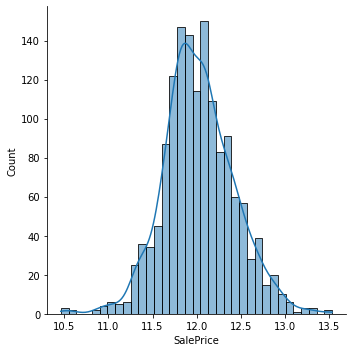

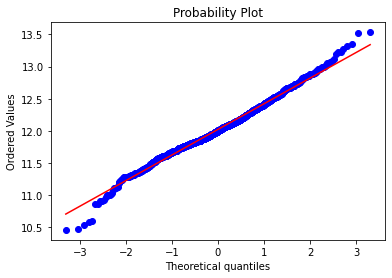

In [9]:
from scipy.stats import norm
from scipy import stats

df_train_norm = df_train.copy()
df_train_norm['SalePrice'] = np.log(df_train['SalePrice'])

sns.displot(df_train_norm['SalePrice'], kde=True);
fig = plt.figure()
res = stats.probplot(df_train_norm['SalePrice'], plot=plt)

以下進行缺失補值，在此訓練集和測試集一同處理比較方便

In [10]:
ntrain = df_train_norm.shape[0]
ntest = df_test.shape[0]
y_train = df_train_norm.SalePrice.values
df = pd.concat((df_train_norm, df_test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(df.shape))

all_data size is : (2917, 79)


數據格式:
有些特徵明明是類別，卻以數值紀錄，要對它做轉換

In [11]:
df['MSSubClass'] = df['MSSubClass'].apply(str)


df['OverallCond'] = df['OverallCond'].astype(str)

df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

處理缺失值，有幾點需要考慮:
1. 缺失值有多少?
2. 缺失值是隨機的? 還是代表某種資訊?
如何看待這件事很重要，因為缺少的值會讓我們能分析的事變少，而且處理缺失值的手法也不能偏離真相

In [12]:
total = df.isnull().sum().sort_values(ascending=False)
miss_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, miss_percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20).T

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageCond,GarageQual,GarageYrBlt,GarageFinish,GarageType,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MasVnrArea,MSZoning,BsmtHalfBath
Total,2908.000000,2812.000000,2719.000000,2346.000000,1420.000000,486.00000,159.000000,159.000000,159.000000,159.000000,157.000000,82.000000,82.000000,81.000000,80.000000,79.000000,24.000000,23.000000,4.000000,2.000000
Percent,0.996915,0.964004,0.932122,0.804251,0.486802,0.16661,0.054508,0.054508,0.054508,0.054508,0.053822,0.028111,0.028111,0.027768,0.027425,0.027083,0.008228,0.007885,0.001371,0.000686


通常，當一種特徵有超過15%遺失時，我們會考慮去掉，假裝它不存在，好讓我們不用煩惱該如何填充。   至於15%以下的，如果有其他Feature可以替代者，也可刪掉(例如Garage系列特徵都可由GarageCars取代)  
當然我們也可以逐一分析，擬定該如何進行填充。

In [13]:
#暴力法
drop_col = missing_data[missing_data['Total']> 0]
try:
    df_brutal_NA = df.drop(labels=drop_col.index,axis=1, inplace=False).copy()
    df_brutal_NA = df_brutal_NA.drop(labels=df_brutal_NA.loc[df_brutal_NA['Electrical'].isnull()].index)
except:
    print("col has been dropped")
    pass

print("缺失值:",df_brutal_NA.isnull().sum().max()) #確認已無缺失值
all_data_na = (df_brutal_NA.isnull().sum() / len(df_brutal_NA)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_col = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_col.head()

col has been dropped
缺失值: 0


,Missing Ratio


In [14]:
#逐一分析法
df_wise_NA = df.copy()
df_wise_NA["PoolQC"] = df_wise_NA["PoolQC"].fillna("None")  #泳池，且該特徵為類別特徵 因此填None
df_wise_NA["MiscFeature"] = df_wise_NA["MiscFeature"].fillna("None")  #額外設施 同上
df_wise_NA["Alley"] = df_wise_NA["Alley"].fillna("None")  # 小道鋪面 同上
df_wise_NA["Fence"] = df_wise_NA["Fence"].fillna("None")  #柵欄隱私度 同上
df_wise_NA["FireplaceQu"] = df_wise_NA["FireplaceQu"].fillna("None")  #壁爐品質 同上
df_wise_NA["LotFrontage"] = df_wise_NA.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))  #這就要小心了，該特徵為與房子相連的街道長，由於每個房子可能都差不多，因此Na填入中值

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):  #車庫相關的類別特徵 沒車庫的會是None
    df_wise_NA[col] = df_wise_NA[col].fillna('None') 

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):  #車庫相關的數值特徵 沒車庫的會是0
    df_wise_NA[col] = df_wise_NA[col].fillna(0)  

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):  #地下室相關的類別特徵 沒有的會是None
    df_wise_NA[col] = df_wise_NA[col].fillna('None')  

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):  #地下室相關的數值特徵 沒有的會是0
    df_wise_NA[col] = df_wise_NA[col].fillna(0)
    
df_wise_NA["MasVnrType"] = df_wise_NA["MasVnrType"].fillna("None")  #房屋飾面種類 類別特徵，沒有的會是None
df_wise_NA["MasVnrArea"] = df_wise_NA["MasVnrArea"].fillna(0)  #房屋飾面面積 數值特徵，沒有的會是0
df_wise_NA['Electrical'] = df_wise_NA['Electrical'].fillna(df_wise_NA['Electrical'].mode()[0])    #關於電力系統 類別特徵 缺失值填為電力系統該有的功能:"SBrkr"
df_wise_NA['MSZoning'] = df_wise_NA['MSZoning'].fillna(df_wise_NA['MSZoning'].mode()[0])  #關於建地類別 類別特徵 填眾數
df_wise_NA = df_wise_NA.drop(['Utilities'], axis=1)  #該缺失值只在測試集出現，且在訓練集中大家都一樣(一例例外)，所以該特徵是冗於特徵，可去除
df_wise_NA["Functional"] = df_wise_NA["Functional"].fillna("Typ")  #數據說明表示Na即為"Typ"

df_wise_NA['Exterior1st'] = df_wise_NA['Exterior1st'].fillna(df_wise_NA['Exterior1st'].mode()[0])  #外牆裝飾 類別特徵 填眾數
df_wise_NA['Exterior2nd'] = df_wise_NA['Exterior2nd'].fillna(df_wise_NA['Exterior2nd'].mode()[0])  #外牆裝飾 類別特徵 填眾數
df_wise_NA['KitchenQual'] = df_wise_NA['KitchenQual'].fillna(df_wise_NA['KitchenQual'].mode()[0])  #廚房品質 類別特徵 填眾數
df_wise_NA['SaleType'] = df_wise_NA['SaleType'].fillna(df_wise_NA['SaleType'].mode()[0])  #出售類別 類別特徵 填眾數

#最後確認還有沒有遺失值
print("缺失值:",df_wise_NA.isnull().sum().max()) #確認已無缺失值
all_data_na = (df_wise_NA.isnull().sum() / len(df_wise_NA)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_col = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_col.head()

缺失值: 0


,Missing Ratio


Featrue Encoding

In [15]:
from sklearn.preprocessing import LabelEncoder


cols = df_wise_NA.select_dtypes(include='object').columns
# import pdb; pdb.set_trace()
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_wise_NA[c].values)) 
    df_wise_NA[c] = lbl.transform(list(df_wise_NA[c].values))

print('Shape all_data: {}'.format(df_wise_NA.shape))

Shape all_data: (2917, 78)


由於房價和坪數相關，因此新增一個特徵:面積總和

In [16]:
df_wise_NA['TotalSF'] = df_wise_NA['TotalBsmtSF'] + df_wise_NA['1stFlrSF'] + df_wise_NA['2ndFlrSF']

處理特徵的偏度

利用Box Cox轉換

In [17]:
def fix_skew(df, ntrain, shew=0.75, lamda = 0.15):
    from scipy.stats import norm, skew
    from scipy.special import boxcox1p
    
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\n Skew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness.head(10).T)
    
    skewness = skewness[abs(skewness['Skew'])>shew]
    print("\n There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    
    skewed_features = skewness.index
    
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], lamda)


In [18]:
fix_skew(df_wise_NA, ntrain, shew=0.75, lamda = 0.15)


 Skew in numerical features: 

        MiscVal   PoolArea    LotArea  Condition2  LowQualFinSF   Heating  \
Skew  21.939672  17.688664  13.109495   12.340989     12.084539  12.07457   

      3SsnPorch  RoofMatl  MiscFeature  LandSlope  
Skew   11.37208  8.722755     5.062388   4.973254  

 There are 49 skewed numerical features to Box Cox transform


In [19]:
#類別轉one-hot
df_wise_NA = pd.get_dummies(df_wise_NA)
print(df_wise_NA.shape)

(2917, 79)


In [20]:
train = df_wise_NA[:ntrain]
test = df_wise_NA[ntrain:]

# 建模

In [21]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

基礎模型

In [22]:
def rmsle_cv(X, y, model, n_folds=5):
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
        rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
        return(rmse)

In [23]:
def simple_model_test(X, y ,n_folds = 5):
    
    lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    Svr = make_pipeline(RobustScaler(), SVR(kernel='linear', degree=3, C=0.5, epsilon=0.1))
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    
    rf = RandomForestRegressor(n_estimators=1200, max_depth=15, min_samples_split=5,
                          min_samples_leaf=5, max_features=None, oob_score=True, random_state=42)

    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
    
    VotingR = VotingRegressor(estimators=[('ls', lasso), ('EN', ENet), ('Svr', Svr), ('kr', KRR), ('rf', rf), ('gb', GBoost)])
    
    
    model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=2200,
                                 reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, random_state =7, nthread = -1)
    model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720,
                                  max_bin = 55, feature_fraction_seed=9, bagging_seed=9)
    
    model_list = {'VR':VotingR, 'XGB':model_xgb, 'LGBM':model_lgb}
    
    for n,m in model_list.items():
        score = rmsle_cv(X, y, m, n_folds)
        print('\n{} score: {:.4f} ({:.4f})\n'.format(n, score.mean(), score.std()))
    return VotingR, model_xgb, model_lgb

In [24]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(m) for m in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [25]:
VotingR, model_xgb, model_lgb = simple_model_test(train, y_train ,n_folds = 5)


VR score: 0.1147 (0.0065)


XGB score: 0.1170 (0.0068)


LGBM score: 0.1219 (0.0067)



In [26]:
averaged_models = AveragingModels(models = (VotingR, model_xgb, model_lgb))

score = rmsle_cv(train, y_train, averaged_models, n_folds = 5)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1141 (0.0065)



法2. 增加meta-model
在這個方法中，基於基礎模型堆疊上，額外增加了一個meta-model，再利用這些基本模型的外插驗證預測(holdout)去訓練meta-model。

In [27]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [28]:
stacked_averaged_models = StackingAveragedModels(models = (VotingR, model_xgb, model_lgb))

score = rmsle_cv(train, y_train, averaged_models, n_folds = 5)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1141 (0.0065)


Ensembling

In [29]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [30]:
# StackedRegressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07351423435153939


In [31]:
#XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07892872267927793


In [32]:
#LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0714301344252994


In [33]:
print('RMSLE score on train data:')
train_pred = stacked_train_pred*0.6 + xgb_train_pred*0.2 + lgb_train_pred*0.2
print(rmsle(y_train, train_pred))
print('平均誤差:', (np.expm1(train_pred)-np.expm1(y_train)).mean())

RMSLE score on train data:
0.07325964844423652
平均誤差: -947.0755204848329


In [34]:
sample = 0
print('真實值: {}, 預測值: {}'.format(np.expm1(y_train[sample]), np.expm1(train_pred[sample])))

真實值: 208499.00000000012, 預測值: 203517.98831869988


In [35]:
#Ensemble prediction:
ensemble = lgb_pred

In [36]:
#Submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)
print("Done")

Done
